In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable **production hydraulique** :

* SARIMAX avec des fonctions sinusoïdales correspondant aux saisons observées en régresseurs exogènes
* SARIMAX avec des données métier en régresseurs exogènes (eau, précipitation).
* SARIMAX avec des données métier FILTREES en régresseurs exogènes
* SARIMAX sur le signal filtré par transformation de Fourier sans régresseur
* SARIMAX sur le signal filtré avec des données métier FILTREES en régresseurs exogènes
* Régression linéaire sur les données métiers FILTREES comme variables explicatives
* Régression linéaire sur la variable à expliquée FILTREE et avec les variables explicatives FILTREES.

**NOTA BENE :** Pour la période 3h, le calcul avec un modèle SARIMAX n'aboutit pas sans données exogènes en paramètre.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_3H.csv',
                usecols = ['Dates', 'Hydraulique'])
df.head(1)

,Dates,Hydraulique
0,2013-01-01 00:00:00,6770.8


In [3]:
df.shape

(25808, 2)

In [4]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [5]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

# Conversion en taux de charge pour annuler l'évolution dans le temps

In [6]:
capa = pd.read_csv('./datasource/capacite_hydraulique_FR.csv',
                  usecols = ['Dates', 'Capa_hyd'])
capa['Dates'] = pd.to_datetime(capa['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
capa.set_index('Dates', inplace = True)

In [7]:
capa.shape

(25808, 1)

In [8]:
df = pd.concat([df, capa], axis = 1)
df['TCH_hyd'] = df['Hydraulique'] / df['Capa_hyd']
df

,Hydraulique,Capa_hyd,TCH_hyd
Dates,,,
2013-01-01 00:00:00,6770.800000,25346,0.267135
2013-01-01 03:00:00,5614.666667,25346,0.221521
2013-01-01 06:00:00,5645.166667,25346,0.222724
2013-01-01 09:00:00,6325.833333,25346,0.249579
2013-01-01 12:00:00,6867.666667,25346,0.270957
...,...,...,...
2021-10-31 09:00:00,3089.500000,25346,0.121893
2021-10-31 12:00:00,2510.500000,25346,0.099049
2021-10-31 15:00:00,2338.500000,25346,0.092263


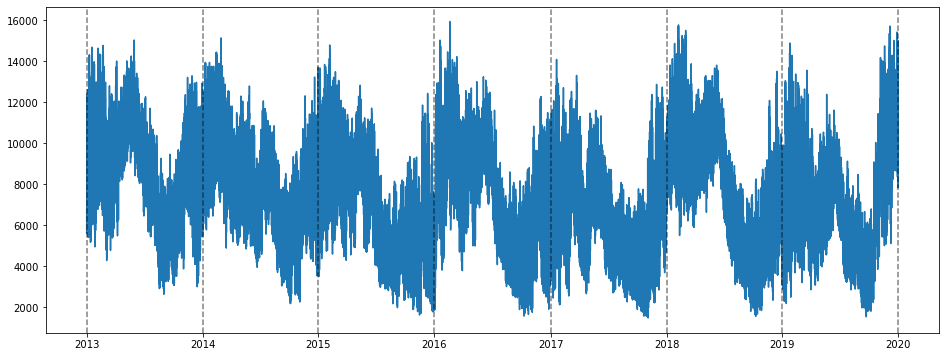

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(df['Hydraulique'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

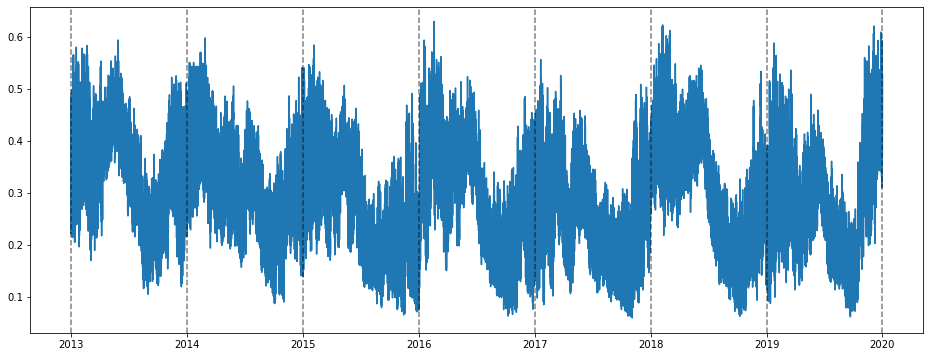

In [10]:
plt.figure(figsize=(16, 6))
plt.plot(df['TCH_hyd'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

### Test de stationnarité

In [11]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df['TCH_hyd'])

(-4.69074596908079,
 8.758654481097686e-05,
 49,
 25758,
 {'1%': -3.4306038998292085,
  '5%': -2.8616522161827964,
  '10%': -2.566829729367711},
 -106489.41251544026)

### Coéfficients SARIMAX et saisonnalités

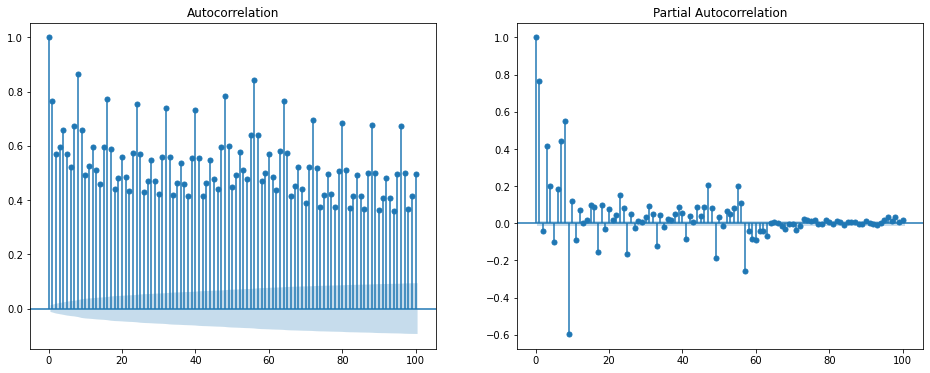

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df['TCH_hyd'], lags = 100, ax=ax1)
plot_pacf(df['TCH_hyd'], lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* 1 an

# Import du dataset filtré (Transformation de Fourier)

In [13]:
df_filtered = pd.read_csv('./dataset/France_3H_filtered.csv',
                usecols = ['Dates', 'Hydraulique'])
df_filtered.head(1)

,Dates,Hydraulique
0,2013-01-01 00:00:00,3697.02044


In [14]:
df_filtered['Dates'] = pd.to_datetime(df_filtered['Dates'], yearfirst = True)
df_filtered.set_index('Dates', inplace = True)

In [15]:
df_filtered = pd.concat([df_filtered, capa], axis = 1)
df_filtered['TCH_hyd'] = df_filtered['Hydraulique'] / df_filtered['Capa_hyd']

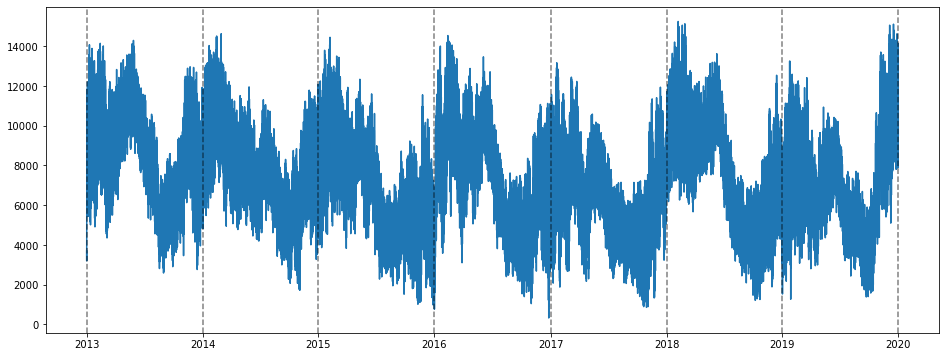

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered['Hydraulique'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

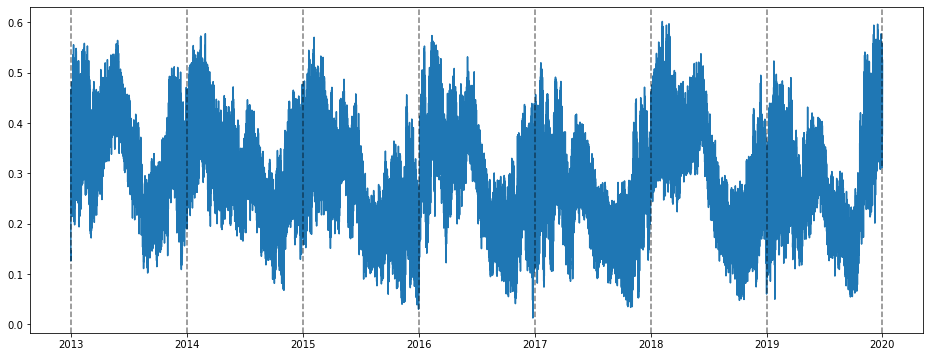

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered['TCH_hyd'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

# Jeux d'entrainement et de test

In [18]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [19]:
df_train_filter = df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)]
df_test_filter = df_filtered[df_filtered.index >= fin]

In [20]:
fenetre = df_test.shape[0]

In [21]:
indice = df_test.index

In [22]:
bilan = df_test

# Paramètres SARIMAX

In [23]:
ordre = (3,0,0)
saison = (2,0,0,8)

# Régresseurs exogènes : sinus & cosinus suivant les saisonnalités

In [24]:
exog = pd.DataFrame({'date': df.index})
exog['date'] = pd.to_datetime(exog['date'])
# suivant saisonnalités
# exog['sin_D'] = np.sin(2 * np.pi * exog.index / 8)
# exog['cos_D'] = np.cos(2 * np.pi * exog.index / 8)
# exog['sin_W'] = np.sin(2 * np.pi * exog.index / 7)
# exog['cos_W'] = np.cos(2 * np.pi * exog.index / 7)
exog['sin_Y'] = np.sin(2 * np.pi * exog.index / 365.25)
exog['cos_Y'] = np.cos(2 * np.pi * exog.index / 365.25)
exog.set_index('date', inplace = True)

In [25]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

<ipython-input-26-56416ee0eedf>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])


''

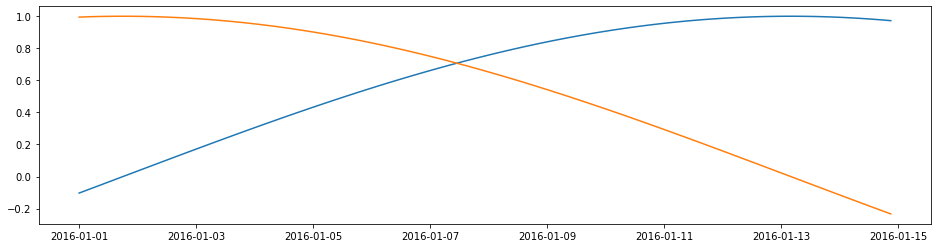

In [26]:
plt.figure(figsize=(16, 4))
plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])
# for year in range(debut.year, fin.year + 1): 
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### SARIMAX

In [27]:
model_sinus = sm.tsa.SARIMAX(df_train['TCH_hyd'].values,
                             exog = exog_train.values,
                             order = ordre,
                             seasonal_order = saison)
result_sinus = model_sinus.fit()

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
predict_sinus = result_sinus.predict(start = 1 ,
                                     end = fenetre,
                                     exog = exog_test.values)

In [29]:
predict_sinus = pd.DataFrame(predict_sinus, columns=['Hyd_p_sinus'], index = indice)

In [30]:
bilan = pd.concat([bilan, predict_sinus], axis = 1)

### Erreur absolue

In [31]:
bilan['Err_sinus'] = np.abs(bilan['Hyd_p_sinus'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus
count,5360.000000,5360.0,5360.000000,5360.000000,5360.000000
mean,7260.388184,25346.0,0.286451,0.321103,0.088204
std,2609.352124,0.0,0.102949,0.095678,0.065891
min,1795.000000,25346.0,0.070820,0.087967,0.000010
25%,5350.208333,25346.0,0.211087,0.252296,0.035179
50%,7097.000000,25346.0,0.280005,0.319804,0.074470
75%,8883.833333,25346.0,0.350502,0.390432,0.126265
max,17214.000000,25346.0,0.679160,0.603015,0.382586


# Régresseurs exogènes : données métier

In [32]:
exog = pd.read_csv('./exog/exog_3H_FR.csv', sep = ';',
                   usecols = ['Dates', 'Eau'])
exog.head(1)

,Dates,Eau
0,2013-01-01 00:00:00,0.292275


In [33]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [34]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [35]:
model_exog = sm.tsa.SARIMAX(df_train['TCH_hyd'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [36]:
result_exog = model_exog.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                20448
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 8)   Log Likelihood               39740.579
Date:                           Wed, 04 May 2022   AIC                         -79467.159
Time:                                   10:05:08   BIC                         -79411.679
Sample:                                        0   HQIC                        -79449.027
                                         - 20448                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -6.3e-05      0.000     -0.469      0.639      -0.000       0.000
ar.L1          0.9118      0.007    128.210      0.000       0.898       0.926
ar.L2         -0.2641      0.009    -28.740      0.000      -0.282      -0.246
ar.L3          0.1878      0.008     25.030      0.000       0.173       0.203
ar.S.L8        0.6357      0.007     88.321      0.000       0.622       0.650
ar.S.L16       0.2542      0.007     36.824      0.000       0.241       0.268
sigma2         0.0012    1.2e-05    100.124      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   2.41   Jarque-Bera (JB):              3799.27
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [38]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [39]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Hyd_p_exog'])

In [40]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [41]:
bilan['Err_exog'] = np.abs(bilan['Hyd_p_exog'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog
count,5360.000000,5360.0,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,7260.388184,25346.0,0.286451,0.321103,0.088204,0.316670,0.084840
std,2609.352124,0.0,0.102949,0.095678,0.065891,0.093569,0.063392
min,1795.000000,25346.0,0.070820,0.087967,0.000010,0.085757,0.000004
25%,5350.208333,25346.0,0.211087,0.252296,0.035179,0.248938,0.034316
50%,7097.000000,25346.0,0.280005,0.319804,0.074470,0.314946,0.071271
75%,8883.833333,25346.0,0.350502,0.390432,0.126265,0.385166,0.120740
max,17214.000000,25346.0,0.679160,0.603015,0.382586,0.592832,0.372403


# Régresseurs exogènes : données métier FILTREES

In [42]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Eau'])
exog.head(1)

,Dates,Eau
0,2013-01-01 00:00:00,3.570189


In [43]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [44]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [45]:
model_filter = sm.tsa.SARIMAX(df_train['TCH_hyd'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [46]:
result_filter = model_filter.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
result_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                20448
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 8)   Log Likelihood               39396.230
Date:                           Wed, 04 May 2022   AIC                         -78778.461
Time:                                   10:07:20   BIC                         -78722.981
Sample:                                        0   HQIC                        -78760.329
                                         - 20448                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0005      0.000      1.210      0.226      -0.000       0.001
ar.L1          0.9900      0.007    141.287      0.000       0.976       1.004
ar.L2         -0.2822      0.009    -30.204      0.000      -0.301      -0.264
ar.L3          0.2456      0.007     34.711      0.000       0.232       0.259
ar.S.L8        0.6518      0.007     95.045      0.000       0.638       0.665
ar.S.L16       0.2411      0.007     35.248      0.000       0.228       0.254
sigma2         0.0012   1.27e-05     97.532      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  23.88   Jarque-Bera (JB):              3187.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [48]:
predict_filter = result_filter.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [49]:
predict_filter = pd.DataFrame(predict_filter, index = indice, columns = ['Hyd_p_filter'])

In [50]:
bilan = pd.concat([bilan, predict_filter], axis = 1)

### Erreur absolue

In [51]:
bilan['Err_exog_filter'] = np.abs(bilan['Hyd_p_filter'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog,Hyd_p_filter,Err_exog_filter
count,5360.000000,5360.0,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03
mean,7260.388184,25346.0,0.286451,0.321103,0.088204,0.316670,0.084840,0.320900,8.680896e-02
std,2609.352124,0.0,0.102949,0.095678,0.065891,0.093569,0.063392,0.096011,6.472702e-02
min,1795.000000,25346.0,0.070820,0.087967,0.000010,0.085757,0.000004,0.082013,8.173221e-08
25%,5350.208333,25346.0,0.211087,0.252296,0.035179,0.248938,0.034316,0.251495,3.524117e-02
50%,7097.000000,25346.0,0.280005,0.319804,0.074470,0.314946,0.071271,0.319622,7.308759e-02
75%,8883.833333,25346.0,0.350502,0.390432,0.126265,0.385166,0.120740,0.390582,1.239484e-01
max,17214.000000,25346.0,0.679160,0.603015,0.382586,0.592832,0.372403,0.608290,3.878606e-01


# Target FILTREE sans régresseur

### SARIMAX

In [52]:
model_reduit_noreg = sm.tsa.SARIMAX(df_train_filter['TCH_hyd'].values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [53]:
result_reduit_noreg = model_reduit_noreg.fit(low_memory=True)

In [54]:
result_reduit_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                20448
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 8)   Log Likelihood               50274.564
Date:                           Wed, 04 May 2022   AIC                        -100537.128
Time:                                   10:08:01   BIC                        -100489.574
Sample:                                        0   HQIC                       -100521.586
                                         - 20448                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3119      0.007    189.737      0.000       1.298       1.325
ar.L2         -0.6767      0.010    -66.360      0.000      -0.697      -0.657
ar.L3          0.3444      0.007     49.758      0.000       0.331       0.358
ar.S.L8        0.9283      0.007    131.588      0.000       0.914       0.942
ar.S.L16       0.0624      0.007      8.842      0.000       0.049       0.076
sigma2         0.0004   4.49e-06     95.310      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                 167.88   Jarque-Bera (JB):             29427.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [55]:
predict_reduit_noreg = result_reduit_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [56]:
predict_reduit_noreg = pd.DataFrame(predict_reduit_noreg, index = indice, columns = ['Hyd_p_reduit_noreg'])

In [57]:
bilan = pd.concat([bilan, predict_reduit_noreg], axis = 1)

### Erreur absolue

In [58]:
bilan['Err_filter_noreg'] = np.abs(bilan['Hyd_p_reduit_noreg'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog,Hyd_p_filter,Err_exog_filter,Hyd_p_reduit_noreg,Err_filter_noreg
count,5360.000000,5360.0,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5360.000000,5360.000000
mean,7260.388184,25346.0,0.286451,0.321103,0.088204,0.316670,0.084840,0.320900,8.680896e-02,0.322392,0.087479
std,2609.352124,0.0,0.102949,0.095678,0.065891,0.093569,0.063392,0.096011,6.472702e-02,0.095018,0.065213
min,1795.000000,25346.0,0.070820,0.087967,0.000010,0.085757,0.000004,0.082013,8.173221e-08,0.068747,0.000028
25%,5350.208333,25346.0,0.211087,0.252296,0.035179,0.248938,0.034316,0.251495,3.524117e-02,0.253741,0.034292
50%,7097.000000,25346.0,0.280005,0.319804,0.074470,0.314946,0.071271,0.319622,7.308759e-02,0.320974,0.075363
75%,8883.833333,25346.0,0.350502,0.390432,0.126265,0.385166,0.120740,0.390582,1.239484e-01,0.391116,0.126627
max,17214.000000,25346.0,0.679160,0.603015,0.382586,0.592832,0.372403,0.608290,3.878606e-01,0.581431,0.359626


# Target FILTREE avec Régresseurs exogènes : données métier FILTREES

In [59]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Eau'])
exog.head(1)

,Dates,Eau
0,2013-01-01 00:00:00,3.570189


In [60]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [61]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [62]:
model_reduit = sm.tsa.SARIMAX(df_train_filter['TCH_hyd'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [63]:
result_reduit = model_reduit.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [64]:
result_reduit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                20448
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 8)   Log Likelihood               50590.280
Date:                           Wed, 04 May 2022   AIC                        -101166.561
Time:                                   10:10:19   BIC                        -101111.081
Sample:                                        0   HQIC                       -101148.429
                                         - 20448                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003      0.000      1.392      0.164      -0.000       0.001
ar.L1          1.2978      0.007    190.200      0.000       1.284       1.311
ar.L2         -0.6721      0.010    -66.501      0.000      -0.692      -0.652
ar.L3          0.3320      0.007     48.628      0.000       0.319       0.345
ar.S.L8        0.9091      0.007    129.291      0.000       0.895       0.923
ar.S.L16       0.0435      0.007      6.206      0.000       0.030       0.057
sigma2         0.0004   4.21e-06     98.447      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                 120.74   Jarque-Bera (JB):             32062.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [65]:
predict_reduit = result_reduit.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [66]:
predict_reduit = pd.DataFrame(predict_reduit, index = indice, columns = ['Hyd_p_reduit'])

In [67]:
bilan = pd.concat([bilan, predict_reduit], axis = 1)

### Erreur absolue

In [68]:
bilan['Err_filter_exog_filter'] = np.abs(bilan['Hyd_p_reduit'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog,Hyd_p_filter,Err_exog_filter,Hyd_p_reduit_noreg,Err_filter_noreg,Hyd_p_reduit,Err_filter_exog_filter
count,5360.000000,5360.0,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5360.000000,5360.000000,5360.000000,5360.000000
mean,7260.388184,25346.0,0.286451,0.321103,0.088204,0.316670,0.084840,0.320900,8.680896e-02,0.322392,0.087479,0.321816,0.086353
std,2609.352124,0.0,0.102949,0.095678,0.065891,0.093569,0.063392,0.096011,6.472702e-02,0.095018,0.065213,0.094157,0.064338
min,1795.000000,25346.0,0.070820,0.087967,0.000010,0.085757,0.000004,0.082013,8.173221e-08,0.068747,0.000028,0.071355,0.000007
25%,5350.208333,25346.0,0.211087,0.252296,0.035179,0.248938,0.034316,0.251495,3.524117e-02,0.253741,0.034292,0.253788,0.033846
50%,7097.000000,25346.0,0.280005,0.319804,0.074470,0.314946,0.071271,0.319622,7.308759e-02,0.320974,0.075363,0.320309,0.074238
75%,8883.833333,25346.0,0.350502,0.390432,0.126265,0.385166,0.120740,0.390582,1.239484e-01,0.391116,0.126627,0.390236,0.124536
max,17214.000000,25346.0,0.679160,0.603015,0.382586,0.592832,0.372403,0.608290,3.878606e-01,0.581431,0.359626,0.578460,0.352967


# Régression linéaire avec Régresseurs exogènes : données métier FILTREES 

In [69]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Eau'])
exog.head(1)

,Dates,Eau
0,2013-01-01 00:00:00,3.570189


In [70]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [71]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [72]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train['TCH_hyd'])
predict_lr = LinReg.predict(exog_test)

In [73]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Hyd_p_LinReg'])

In [74]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [75]:
bilan['Err_LinReg'] = np.abs(bilan['Hyd_p_LinReg'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog,Hyd_p_filter,Err_exog_filter,Hyd_p_reduit_noreg,Err_filter_noreg,Hyd_p_reduit,Err_filter_exog_filter,Hyd_p_LinReg,Err_LinReg
count,5360.000000,5360.0,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,7260.388184,25346.0,0.286451,0.321103,0.088204,0.316670,0.084840,0.320900,8.680896e-02,0.322392,0.087479,0.321816,0.086353,0.285056,0.082179
std,2609.352124,0.0,0.102949,0.095678,0.065891,0.093569,0.063392,0.096011,6.472702e-02,0.095018,0.065213,0.094157,0.064338,0.006965,0.062076
min,1795.000000,25346.0,0.070820,0.087967,0.000010,0.085757,0.000004,0.082013,8.173221e-08,0.068747,0.000028,0.071355,0.000007,0.271036,0.000006
25%,5350.208333,25346.0,0.211087,0.252296,0.035179,0.248938,0.034316,0.251495,3.524117e-02,0.253741,0.034292,0.253788,0.033846,0.280861,0.033463
50%,7097.000000,25346.0,0.280005,0.319804,0.074470,0.314946,0.071271,0.319622,7.308759e-02,0.320974,0.075363,0.320309,0.074238,0.283530,0.069933
75%,8883.833333,25346.0,0.350502,0.390432,0.126265,0.385166,0.120740,0.390582,1.239484e-01,0.391116,0.126627,0.390236,0.124536,0.287188,0.118113
max,17214.000000,25346.0,0.679160,0.603015,0.382586,0.592832,0.372403,0.608290,3.878606e-01,0.581431,0.359626,0.578460,0.352967,0.351224,0.388001


# Régression linéaire sur target FILTREE avec Régresseurs exogènes : données métier FILTREES 

In [76]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Eau'])
exog.head(1)

,Dates,Eau
0,2013-01-01 00:00:00,3.570189


In [77]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [78]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [79]:
LinReg_filter = LinearRegression()
LinReg_filter.fit(exog_train, df_train_filter['TCH_hyd'])
predict_lr_filter = LinReg_filter.predict(exog_test)

In [80]:
predict_lr_filter = pd.DataFrame(predict_lr_filter, index = indice, columns = ['Hyd_p_LinReg_filter'])

In [81]:
bilan = pd.concat([bilan, predict_lr_filter], axis = 1)

### Erreur absolue

In [82]:
bilan['Err_LinReg_filter'] = np.abs(bilan['Hyd_p_LinReg_filter'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog,Hyd_p_filter,Err_exog_filter,Hyd_p_reduit_noreg,Err_filter_noreg,Hyd_p_reduit,Err_filter_exog_filter,Hyd_p_LinReg,Err_LinReg,Hyd_p_LinReg_filter,Err_LinReg_filter
count,5360.000000,5360.0,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,7260.388184,25346.0,0.286451,0.321103,0.088204,0.316670,0.084840,0.320900,8.680896e-02,0.322392,0.087479,0.321816,0.086353,0.285056,0.082179,0.285045,0.082181
std,2609.352124,0.0,0.102949,0.095678,0.065891,0.093569,0.063392,0.096011,6.472702e-02,0.095018,0.065213,0.094157,0.064338,0.006965,0.062076,0.007067,0.062081
min,1795.000000,25346.0,0.070820,0.087967,0.000010,0.085757,0.000004,0.082013,8.173221e-08,0.068747,0.000028,0.071355,0.000007,0.271036,0.000006,0.270820,0.000051
25%,5350.208333,25346.0,0.211087,0.252296,0.035179,0.248938,0.034316,0.251495,3.524117e-02,0.253741,0.034292,0.253788,0.033846,0.280861,0.033463,0.280788,0.033443
50%,7097.000000,25346.0,0.280005,0.319804,0.074470,0.314946,0.071271,0.319622,7.308759e-02,0.320974,0.075363,0.320309,0.074238,0.283530,0.069933,0.283496,0.069988
75%,8883.833333,25346.0,0.350502,0.390432,0.126265,0.385166,0.120740,0.390582,1.239484e-01,0.391116,0.126627,0.390236,0.124536,0.287188,0.118113,0.287209,0.118140
max,17214.000000,25346.0,0.679160,0.603015,0.382586,0.592832,0.372403,0.608290,3.878606e-01,0.581431,0.359626,0.578460,0.352967,0.351224,0.388001,0.352183,0.387922


# Calcul de la prediction : TCH x Capacité

In [83]:
bilan['Hyd_p_sinus'] = bilan['Hyd_p_sinus'] * bilan['Capa_hyd']
bilan['Err_sinus'] = bilan['Err_sinus'] * bilan['Capa_hyd']
bilan['Hyd_p_exog'] = bilan['Hyd_p_exog'] * bilan['Capa_hyd']
bilan['Err_exog'] = bilan['Err_exog'] * bilan['Capa_hyd']
bilan['Hyd_p_filter'] = bilan['Hyd_p_filter'] * bilan['Capa_hyd']
bilan['Err_exog_filter'] = bilan['Err_exog_filter'] * bilan['Capa_hyd']
bilan['Hyd_p_reduit_noreg'] = bilan['Hyd_p_reduit_noreg'] * bilan['Capa_hyd']
bilan['Err_filter_noreg'] = bilan['Err_filter_noreg'] * bilan['Capa_hyd']
bilan['Hyd_p_reduit'] = bilan['Hyd_p_reduit'] * bilan['Capa_hyd']
bilan['Err_filter_exog_filter'] = bilan['Err_filter_exog_filter'] * bilan['Capa_hyd']
bilan['Hyd_p_LinReg'] = bilan['Hyd_p_LinReg'] * bilan['Capa_hyd']
bilan['Err_LinReg'] = bilan['Err_LinReg'] * bilan['Capa_hyd']
bilan['Hyd_p_LinReg_filter'] = bilan['Hyd_p_LinReg_filter'] * bilan['Capa_hyd']
bilan['Err_LinReg_filter'] = bilan['Err_LinReg_filter'] * bilan['Capa_hyd']
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog,Hyd_p_filter,Err_exog_filter,Hyd_p_reduit_noreg,Err_filter_noreg,Hyd_p_reduit,Err_filter_exog_filter,Hyd_p_LinReg,Err_LinReg,Hyd_p_LinReg_filter,Err_LinReg_filter
count,5360.000000,5360.0,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,7260.388184,25346.0,0.286451,8138.683347,2235.628878,8026.308227,2150.354827,8133.537459,2200.259910,8171.355487,2217.245448,8156.744706,2188.711046,7225.021802,2082.911347,7224.743865,2082.954843
std,2609.352124,0.0,0.102949,2425.058187,1670.066510,2371.602095,1606.726106,2433.498619,1640.571029,2408.319027,1652.895735,2386.500795,1630.706145,176.541035,1573.387623,179.128817,1573.506470
min,1795.000000,25346.0,0.070820,2229.622176,0.249491,2173.590512,0.090748,2078.707108,0.002072,1742.464318,0.703016,1808.575360,0.174679,6869.689282,0.153563,6864.202792,1.293014
25%,5350.208333,25346.0,0.211087,6394.688229,891.656596,6309.594590,869.785909,6374.404622,893.222705,6431.323347,869.177412,6432.514038,857.868943,7118.693700,848.147916,7116.857179,847.638411
50%,7097.000000,25346.0,0.280005,8105.754487,1887.508226,7982.620050,1806.441143,8101.127710,1852.478049,8135.398494,1910.138417,8118.554062,1881.626437,7186.341162,1772.528854,7185.496235,1773.909269
75%,8883.833333,25346.0,0.350502,9895.894589,3200.319533,9762.415177,3060.279763,9899.697170,3141.594923,9913.215716,3209.485283,9890.910759,3156.488036,7279.072326,2993.687426,7279.586675,2994.383275
max,17214.000000,25346.0,0.679160,15284.015993,9697.015993,15025.931639,9438.931639,15417.714721,9830.714721,14736.952938,9115.088004,14661.656601,8946.299498,8902.131842,9834.265700,8926.437399,9832.275823


# Visualisation réel vs prédictions

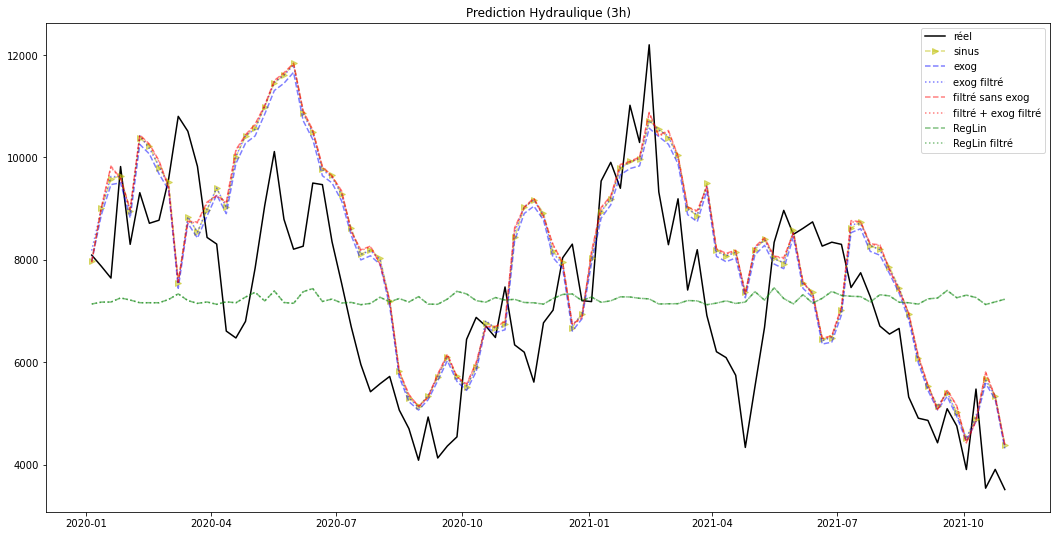

In [89]:
plt.figure(figsize=(18,9))
plt.plot(bilan['Hydraulique'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Hyd_p_sinus'].resample('W').mean(), color = 'y', linestyle = '--', alpha = 0.5, label = 'sinus', marker = '>')
plt.plot(bilan['Hyd_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Hyd_p_filter'].resample('W').mean(), color = 'b', linestyle = ':', alpha = 0.5, label = 'exog filtré')
plt.plot(bilan['Hyd_p_reduit_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Hyd_p_reduit'].resample('W').mean(), color = 'r', linestyle = ':', alpha = 0.5, label = 'filtré + exog filtré')
plt.plot(bilan['Hyd_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.plot(bilan['Hyd_p_LinReg_filter'].resample('W').mean(), color = 'g', linestyle = ':', alpha = 0.5, label = 'RegLin filtré')
plt.legend(loc = 'upper right')
plt.title('Prediction Hydraulique (3h)')
plt.savefig('./results/3h/pred_hydraulique_3h.png');

# Synthèse des erreurs

In [90]:
erreur = bilan[['Err_sinus',
       'Err_exog',
       'Err_exog_filter',
       'Err_filter_noreg',
       'Err_filter_exog_filter',
       'Err_LinReg',
       'Err_LinReg_filter'
      ]].describe()
erreur

,Err_sinus,Err_exog,Err_exog_filter,Err_filter_noreg,Err_filter_exog_filter,Err_LinReg,Err_LinReg_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,2235.628878,2150.354827,2200.259910,2217.245448,2188.711046,2082.911347,2082.954843
std,1670.066510,1606.726106,1640.571029,1652.895735,1630.706145,1573.387623,1573.506470
min,0.249491,0.090748,0.002072,0.703016,0.174679,0.153563,1.293014
25%,891.656596,869.785909,893.222705,869.177412,857.868943,848.147916,847.638411
50%,1887.508226,1806.441143,1852.478049,1910.138417,1881.626437,1772.528854,1773.909269
75%,3200.319533,3060.279763,3141.594923,3209.485283,3156.488036,2993.687426,2994.383275
max,9697.015993,9438.931639,9830.714721,9115.088004,8946.299498,9834.265700,9832.275823


In [91]:
bilan.to_csv('./results/3h/bilan_hydraulique_3h.csv', sep = ';')
erreur.to_csv('./results/3h/erreur_hydraulique_3h.csv', sep = ';')